# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Filesystem-parameters" data-toc-modified-id="Filesystem-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Filesystem parameters</a></div><div class="lev1 toc-item"><a href="#Grism-and-Filter-Properties" data-toc-modified-id="Grism-and-Filter-Properties-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Grism and Filter Properties</a></div><div class="lev1 toc-item"><a href="#Load-Catalogues" data-toc-modified-id="Load-Catalogues-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Catalogues</a></div><div class="lev1 toc-item"><a href="#Compute-Galaxy-Size" data-toc-modified-id="Compute-Galaxy-Size-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compute Galaxy Size</a></div><div class="lev1 toc-item"><a href="#Compute-&quot;Cleanliness&quot;-for-Stamps" data-toc-modified-id="Compute-&quot;Cleanliness&quot;-for-Stamps-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compute "Cleanliness" for Stamps</a></div><div class="lev1 toc-item"><a href="#Merge-Catalogue-quantities-with-cleanliness-metric" data-toc-modified-id="Merge-Catalogue-quantities-with-cleanliness-metric-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Merge Catalogue quantities with cleanliness metric</a></div>

# Imports

In [1]:
import astropy.io.fits as astrofits
import astropy.units as astrounits
import numpy as np
import scipy as sp
import pandas as pd
import glob
import gc
import re
import pathlib
from IPython.core.display import display
import matplotlib
from matplotlib import pyplot as mplplot
%matplotlib inline

# Filesystem parameters

In [2]:
pointingId = 96
pipelineVersion = 6.2
dataPath = '/Volumes/ramon2_wisps/data/V{}'.format(pipelineVersion)
pointingPath = '{}/Par{}'.format(dataPath, pointingId)
objectCatalogPaths = glob.glob('{}/SEX/*.cat'.format(pointingPath))
g141StampPaths = glob.glob('{}/G141_DRIZZLE/*mef*.fits'.format(pointingPath))
g102StampPaths = glob.glob('{}/G102_DRIZZLE/*mef*.fits'.format(pointingPath))

# Grism and Filter Properties

In [3]:
defaultGrismToFilterMap = {102 : [110, 140, 160], 
                           141 : [160, 140, 110]}

# Retrieved from: The online Filter Profile Service (http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=HST&gname2=WFC3_IR)
defaultFilterPivotWavelengths = {110 : 11534.46*astrounits.angstrom,
                                 160 : 15370.33*astrounits.angstrom,
                                 102 : 9989.59*astrounits.angstrom}

# Characteristics of the blue and red grisms.
defaultGrismWavelengthRanges = {102 : (800,1150)*astrounits.nanometer,
                                141 : (1075,1700)*astrounits.nanometer}

defaultGrismCrossoverWavelength = 0.5*(defaultGrismWavelengthRanges[102][1] + defaultGrismWavelengthRanges[141][0])

defaultGrismResolvingPowers = {102 : 210,
                               141 : 130}

defaultGrismResolvingPowerWavelengths = {102 : 1000*astrounits.nanometer,
                                         141 : 1400*astrounits.nanometer}

# Retrieved from: http://www.stsci.edu/hst/wfc3/analysis/grism_obs/wfc3-grism-resources.html
defaultGrismDispersionsNmPerPixel = {102 : 2.45*astrounits.nanometer,
                                     141 : 4.65*astrounits.nanometer}

defaultGrismPixelBounds = {102 : np.linspace(start=defaultGrismWavelengthRanges[102][0],
                                             stop=defaultGrismWavelengthRanges[102][1],
                                             num=(defaultGrismWavelengthRanges[102][1] - defaultGrismWavelengthRanges[102][0])/defaultGrismDispersionsNmPerPixel[102]
                                             ),
                           141 : np.linspace(start=defaultGrismWavelengthRanges[141][0],
                                             stop=defaultGrismWavelengthRanges[141][1],
                                             num=(defaultGrismWavelengthRanges[141][1] - defaultGrismWavelengthRanges[141][0])/defaultGrismDispersionsNmPerPixel[141]
                                             )
                           }

# Load Catalogues

In [4]:
catalogueColumns = ['NUMBER',
'X_IMAGE',
'Y_IMAGE',
'A_IMAGE',
'B_IMAGE',
'THETA_IMAGE',
'X_WORLD',
'Y_WORLD',
'A_WORLD',
'B_WORLD',
'THETA_WORLD',
'MAG_AUTO',
'MAGERR_AUTO',
'CLASS_STAR',
'FLAGS',
'BADPIXLE_RATIO',
'FLAG2']

catalogueDescriptions = ['Running object number',
'Object position along x',
'Object position along y',
'Profile RMS along major axis',
'Profile RMS along minor axis',
'Position angle (CCW/x)',
'Barycenter position along world x axis',
'Barycenter position along world y axis',
'Profile RMS along major axis (world units)',
'Profile RMS along minor axis (world units)',
'Position angle (CCW/world-x)',
'Kron-like elliptical aperture magnitude',
'RMS error for AUTO magnitude',
'S/G classifier output',
'Extraction flags',
'N_badpixel/N_total']

catalogueUnits = [None,
'pixel',
'pixel',
'pixel',
'pixel',
'deg',
'deg',
'deg',
'deg',
'deg',
'deg',
'mag',
'mag',
 None,
 None,
 None]

In [5]:
objectCatalogues = { pathlib.Path(path).stem : pd.read_csv(path,
                                                           delim_whitespace=True,
                                                           header=None,
                                                           names=catalogueColumns, 
                                                           comment='#', 
                                                           engine='c') for path in objectCatalogPaths }

# Compute Galaxy Size
Maybe `A_WORLD` suffices for this?

# Compute "Cleanliness" for Stamps

In [7]:
g141StampCleanlinesses = []
g102StampCleanlinesses = []

g141StampObjects = []
g102StampObjects = []

for stampPath in g141StampPaths :
    stampHdus = astrofits.open(stampPath)
    contamExtension = stampHdus['CON'].data
    modelExtension = stampHdus['MOD'].data
    multipliedExtensions = (contamExtension > 0) & (modelExtension > 0)
    cleanliness = np.sum(multipliedExtensions)
    g141StampCleanlinesses.append(cleanliness)
    stampObject = None
    try :
        stampObject = int(re.search(r'.*aXeWFC3_G141_mef_ID([0-9]+).fits', stampPath).group(1))
        g141StampObjects.append(stampObject)
    except Exception as error :
        print ('Could not determine object/beam ID.')
        g141StampObjects.append(None)
    
for stampPath in g102StampPaths :
    stampHdus = astrofits.open(stampPath)
    contamExtension = stampHdus['CON'].data
    modelExtension = stampHdus['MOD'].data
    multipliedExtensions = (contamExtension > 0) & (modelExtension > 0)
    cleanliness = np.sum(multipliedExtensions)
    g102StampCleanlinesses.append(cleanliness)
    stampObject = None
    try :
        stampObject = int(re.search(r'.*aXeWFC3_G102_mef_ID([0-9]+).fits', stampPath).group(1))
        g102StampObjects.append(stampObject)
    except Exception as error :
        print ('Could not determine object/beam ID.')
        g102StampObjects.append(None)

In [8]:
g141StampCleanlinessFrame = pd.DataFrame.from_dict({'OBJECT' : g141StampObjects, 'CLEANLINESS' : g141StampCleanlinesses}).sort_values(by=['OBJECT'])
g102StampCleanlinessFrame = pd.DataFrame.from_dict({'OBJECT' : g102StampObjects, 'CLEANLINESS' : g102StampCleanlinesses}).sort_values(by=['OBJECT'])
display(g141StampCleanlinessFrame)

,CLEANLINESS,OBJECT
616,946,1
246,1362,2
377,1856,3
916,4311,4
536,3422,5
168,1309,6
299,2420,7
835,2826,8
713,545,9
756,3422,10


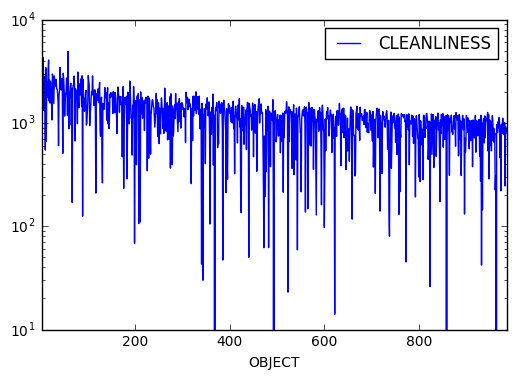

In [9]:
g141StampCleanlinessFrame[g141StampCleanlinessFrame['OBJECT'] < 5000].plot.line(x='OBJECT', y='CLEANLINESS', logy=True)

# Merge Catalogue quantities with cleanliness metric

In [10]:
print(objectCatalogues.keys())

dict_keys(['F160W_DIM_full', 'F110W_SIM_full', 'F110W_DIM_full', 'F160W_SIM_full'])


In [11]:
g141DIMFrame = g141StampCleanlinessFrame.merge(objectCatalogues['F160W_DIM_full'], left_on='OBJECT', right_on='NUMBER')
g141SIMFrame = g141StampCleanlinessFrame.merge(objectCatalogues['F160W_SIM_full'], left_on='OBJECT', right_on='NUMBER')
g102DIMFrame = g102StampCleanlinessFrame.merge(objectCatalogues['F110W_DIM_full'], left_on='OBJECT', right_on='NUMBER')
g102SIMFrame = g102StampCleanlinessFrame.merge(objectCatalogues['F110W_SIM_full'], left_on='OBJECT', right_on='NUMBER')

In [12]:
display(g141DIMFrame)

,CLEANLINESS,OBJECT,NUMBER,X_IMAGE,Y_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,X_WORLD,Y_WORLD,A_WORLD,B_WORLD,THETA_WORLD,MAG_AUTO,MAGERR_AUTO,CLASS_STAR,FLAGS,BADPIXLE_RATIO,FLAG2
0,946,1,1,901.412,165.017,1.301,0.829,-6.8,32.369972,-4.730588,0.000029,0.000019,81.3,26.1783,99.0000,0.00,0,0.0238,9
1,1362,2,2,220.009,1687.009,2.090,1.081,51.4,32.341125,-4.707207,0.000045,0.000026,29.7,20.2850,0.2974,1.00,2,0.0100,9
2,1856,3,3,817.763,1686.035,1.816,1.436,75.2,32.337696,-4.720043,0.000040,0.000032,-0.3,24.5958,0.1069,0.00,3,0.0156,9
3,4311,4,4,823.611,1684.255,2.377,1.667,23.6,32.337700,-4.720179,0.000053,0.000037,56.3,24.2796,0.0993,0.00,3,0.0083,9
4,3422,5,5,563.132,1683.095,3.135,1.790,28.6,32.339230,-4.714594,0.000070,0.000039,52.3,25.8135,0.2708,0.00,0,0.0051,9
5,1309,6,6,1408.113,1684.132,2.930,1.756,6.7,32.334328,-4.732726,0.000066,0.000038,69.4,24.6761,0.0753,0.00,0,0.1667,9
6,2420,7,7,799.374,1685.417,2.910,1.293,0.3,32.337814,-4.719652,0.000065,0.000029,74.8,25.5038,0.2622,0.00,0,0.1538,9
7,2826,8,8,1807.287,1684.061,1.405,1.198,-77.4,32.332024,-4.741294,0.000031,0.000026,-25.2,25.6609,0.2115,0.00,0,0.0238,9
8,545,9,9,1785.140,1684.169,1.546,1.341,-26.0,32.332150,-4.740818,0.000034,0.000030,-76.5,26.0848,1.1170,0.00,0,0.0204,9
9,3422,10,10,1462.446,1677.519,3.898,3.153,71.3,32.334156,-4.733930,0.000085,0.000071,4.4,24.0571,0.0746,0.00,0,0.0035,9
